<a href="https://colab.research.google.com/github/ansariminhaj/ULIME/blob/main/Single_Image_ULIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import skimage.io 
import skimage.segmentation
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
import sys
import torch.optim as optim
import cv2, os, math
from PIL import Image
import requests
import ast
from itertools import product
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline

### **Parameters**

In [19]:
SEED = 123
RUNS = 10
ULIME = 1 #0 LIME, 1 ULIME
perturbations_quantity = [10, 50]#, 100, 200]#, 300, 500, 700, 1000, 1500, 2000, 2500, 3000]
img_path = 'images/soccer.jpg'
img_class = 805
save_folder = 'images/soccer_explanation'

### **Set Seed**

In [4]:
np.random.seed(SEED)

### **Load Model and Transformations/Inverse Transformations**

In [5]:
net1_loaded = torchvision.models.inception_v3(pretrained=True) #Load pretrained model
net1_loaded.cuda()

#InceptionV3 ImageNet Transformation
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inv_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
])

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

### **Load Image and Superpixilize**

20


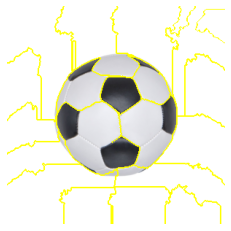

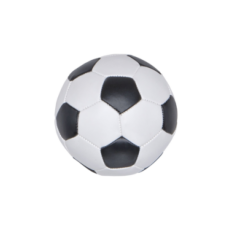

In [20]:
Xi = Image.open(img_path)
img_tensor = preprocess(Xi)
img_batch = img_tensor.unsqueeze_(0).float()
img_batch = img_batch.to(device)
img_batch_clone = img_batch.clone()
img_for_perturbation = img_batch_clone.squeeze_(0).cpu().permute(1, 2, 0).numpy() 

superpixels = skimage.segmentation.quickshift(img_for_perturbation.astype('float'), kernel_size=8,max_dist=100, ratio=0.1) #for cat
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)

i_view = inv_preprocess(img_for_perturbation)
i_view = i_view.squeeze_(0).cpu().permute(1, 2, 0).numpy() 

plt.imshow(skimage.segmentation.mark_boundaries(i_view, superpixels))
plt.axis('off')
plt.savefig(save_folder+'/seg_image.png', bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(i_view)
plt.axis('off')
plt.savefig(save_folder+'/org_image.png', bbox_inches='tight')
plt.show()
plt.close()

### **Run LIME *RUNS* number of times. Normalize and save coefficients.**

In [21]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

coeffs_list = []
for i in range(RUNS):        
    print("RUN: ", i+1)

    probability_list = []
    coeff_list = []

    for p in perturbations_quantity:
        num_perturb = p
        perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
        perturbations = np.array(list(set(map(tuple, perturbations)))) #Remove Duplicates

        predictions = []

        for pert in perturbations:
            perturbed_img = perturb_image(img_for_perturbation,pert,superpixels)
            perturbed_batch = transforms.ToTensor()(perturbed_img).unsqueeze_(0)
            perturbed_batch = perturbed_batch.float()
            perturbed_batch = perturbed_batch.to(device)

            net1_loaded.eval()

            pred = net1_loaded(perturbed_batch)
            pred = pred.detach()
            predictions.append(np.array(pred.cpu()))

            probabilities = torch.nn.functional.softmax(pred[0], dim=0)

        predictions = np.array(predictions)

        original_image = np.ones(num_superpixels) 
        original_image = original_image[np.newaxis,:]
        distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='l2').ravel()

        kernel_width = 0.25
        weights = np.exp(-(distances**2)/kernel_width**2) #Kernel function
        if ULIME == 1:
          weights = np.ones(weights.shape[0]) 

        class_to_explain = img_class
        simpler_model = LinearRegression()
        simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
        coeff = simpler_model.coef_[0]
        coeff_norm = [(float(i)-min(coeff))/(max(coeff)-min(coeff)) for i in coeff]
        coeff_list.append(coeff_norm)
        # [[coeffs for 1st pert num], [coeffs for 2nd pert num], [coeffs for 3rd pert num] ... [coeffs for 12th pert num]]

    coeffs_list.append(coeff_list)
    #[[all coeffs run 1], [all coeffs run 2] ... [all coeffs run 10]]

RUN:  1
RUN:  2
RUN:  3
RUN:  4
RUN:  5
RUN:  6
RUN:  7
RUN:  8
RUN:  9
RUN:  10


### **Save coefficients in a file**

In [22]:
fc= open(save_folder+"/coeffs_list.txt","w+")
fc.write("Class: "+str(img_class))
fc.write("\n")
fc.write(str(coeffs_list))
fc.write("\n\n")
fc.close()

### **(LnO) Find the classification values as *k* increases from *1* to *N***

In [23]:
probability_list_run = []
probability_list_pert = []
for i in range(RUNS): #Runs
    probability_list_pert=[]
    for j in range(len(perturbations_quantity)): #Perturbations
        probability_list_n=[]

        for k in range(0, len(coeffs_list[i][j])+1): #Coefficients
            num_top_features = k
            if num_top_features == 0:
                top_features = []
            else:
                top_features = np.argsort(coeffs_list[i][j])[-num_top_features:] 

            mask = np.ones(num_superpixels) 
            mask[top_features]= False
            explanation = perturb_image(img_for_perturbation,mask,superpixels)

            perturbed_batch = transforms.ToTensor()(explanation).unsqueeze_(0)
            perturbed_batch = perturbed_batch.float()

            net1_loaded.eval()
            outputs = net1_loaded(perturbed_batch.to(device))
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            probability_list_n.append(np.array(probabilities.detach().cpu())[img_class])

        probability_list_pert.append(probability_list_n)
    probability_list_run.append(probability_list_pert)

### **Save LnO values in a file**

In [24]:
f= open(save_folder+"/LnO.txt","w+")
for i in range(RUNS):
    f.write("RUN: %d\n\n" % i)
    for j in range(len(perturbations_quantity)):
        f.write("PERTURBATION: %d\n" % perturbations_quantity[j])
        f.write(str(probability_list_run[i][j]))
        f.write("\n")
f.close()

### **Rearrange LnO values for graphing**

In [25]:
n_list = [n for n in range(num_superpixels+1)]
_list1 = []
_list2 = []

for j in range(len(perturbations_quantity)):
    _list1=[]
    for i in range(RUNS):
        _list1.append(probability_list_run[i][j])
    _list2.append(_list1)
print(len(_list2[0][0]))

21


### **Graph LnO Values**
#### **1st loop graphs each LnO individually**
#### **2nd loop graphs them together** 

In [26]:
os.mkdir(save_folder+'/LnO')
for j in range(len(perturbations_quantity)):
    os.mkdir(save_folder+'/LnO/'+str(perturbations_quantity[j]))
    for i in range(RUNS):
        plt.xlabel("n")
        plt.ylabel("LnO Accuracy")
        plt.plot(n_list, _list2[j][i])
        plt.savefig(save_folder+'/LnO/'+str(perturbations_quantity[j])+"/run_"+str(i)+'.png', bbox_inches='tight')
        plt.close()

for j in range(len(perturbations_quantity)):
    for i in range(RUNS):
        plt.xlabel("n")
        plt.ylabel("LnO Accuracy")
        plt.plot(n_list, _list2[j][i])
    plt.savefig(save_folder+'/LnO/'+str(perturbations_quantity[j])+"/all_runs.png", bbox_inches='tight')
    plt.close()

### **Plot Heatmaps of the explanations using saved coefficients**

In [27]:
def heatmap_image(img,c_list,segments):
    num_superpixels = np.unique(segments).shape[0]
    mask = np.zeros(segments.shape)
    for i in range(num_superpixels):
        mask[segments == i] = c_list[i] 
    return mask

os.mkdir(save_folder+"/heatmaps")
for i in range(RUNS):
    os.mkdir(save_folder+"/heatmaps/"+"RUN "+str(i))
    for j in range(len(perturbations_quantity)):
        heat_img = heatmap_image(img_for_perturbation,coeffs_list[i][j],superpixels)
        plt.imshow(heat_img)
        plt.axis('off')
        plt.savefig(save_folder+"/heatmaps/"+"RUN "+str(i)+"/"+str(perturbations_quantity[j])+".png", bbox_inches='tight')
        plt.close()

### **Rearrange coefficients for graphing variance**

In [28]:
l1=[]
l2=[]
l3=[]

for j in range(len(perturbations_quantity)): #Pick perturbation number
    for k in range(len(probability_list_run[0][0])-1): #Coefficients
        for i in range(RUNS): 
            l1.append(coeffs_list[i][j][k]) #List of kth coeff of all runs for perturbation j 
        l2.append(l1) #List all coeffs for perturbation j 
        l1=[]
    l3.append(l2) #List of all perturbations 
    l2 = []

### **Graph Variance**

Perturbation:  10 

Mean:  10.543958222175258
Var:  4.567239636501927
Perturbation:  50 

Mean:  9.253257190820545
Var:  1.0693469213251743


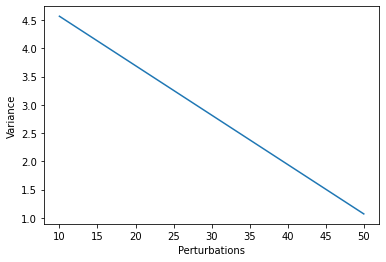

In [29]:
total_var_l = []
total_mean_l = []
f= open(save_folder+"/pert_var.txt","w+")
for k in range(len(perturbations_quantity)):
    print("Perturbation: ", perturbations_quantity[k],"\n")
    f.write("Perturbation: " + str(perturbations_quantity[k]) +"\n")
    total_var = 0
    total_mean = 0
    for i in range(len(l3[k])): #go through all coefficients
        total_var += np.var(l3[k][i])
        total_mean += np.mean(l3[k][i])
        for j in range(i+1, len(l3[k])):
            total_var += 2 * np.cov(l3[k][i], l3[k][j], ddof=0)[0][1] #Extract covariance value from covariance matrix
    print("Mean: ", total_mean)
    print("Var: ",total_var)
    f.write("Mean: "+str(total_mean)+"\n")
    f.write("Var: "+str(total_var)+"\n")
    total_var_l.append(total_var)
f.close()

plt.xlabel("Perturbations")
plt.ylabel("Variance")
plt.plot(perturbations_quantity, total_var_l)
plt.savefig(save_folder+'/pert_var.png', bbox_inches='tight')